# 项目概览与 quantclassic 调用说明

## 1. 场景与目标

- 任务：基于日频 A 股行情和行业信息，构建多因子时序图模型，输出截面因子并做回测。

- 数据范围：2000-2025 年；来源包含 Wind 合并数据 `merged_data.parquet` 与米筐（rqdatac）接口（可选全量抓取）。

- 结果：生成处理后特征/标签、静态行业图与动态图训练结果、多因子回测报告，以及按实验隔离的归档目录。

## 2. 数据处理与预处理

- 数据整理：从 `日度数据与日度特征-中邮/merged_data.parquet` 读取，筛选 2000-2025，字段映射为 `open/high/low/close/vol/amount/vwap`、`trade_date`、`order_book_id`、`industry_code`，保存到 `output/wind_daily_features.parquet`。

- 预处理管道（quantclassic.data_processor）：

  - 标签生成：`y_ret_1d/5d/10d` 简单收益，研报基准使用 `y_ret_10d` 做 SimStock 标签中性化（`alpha_label`）。

  - 清洗：可选去极值、标准化、中性化；缺失值中位数填充；标签在 Dataset 内做窗口排名标准化避免泄露。

  - 输出：`output/caitong_processed_all.parquet`（或 `wind_processed_all.parquet`）。

## 3. 模型与配置（quantclassic.model）

- 数据配置 `DataConfig`：窗口 `window_size=150`，滚动窗口 2268 天、步长 252 天，启用价格对数与量纲归一，支持缓存。

- 模型配置 `CompositeModelConfig`：

  - 时序模块 `TemporalModuleConfig`：LSTM+自注意力，残差与 dropout。

  - 图模块 `GraphModuleConfig`：GAT，top_k=10，支持静态行业图或动态图。

  - 融合模块 `FusionModuleConfig`：两层 MLP，`output_dim=N_FACTORS=64` 生成多因子截面矩阵。

  - 训练：`n_epochs=20`，`batch_size=1000`，Adam，Plateau 调度器，可选相关性正则化 `lambda_corr`。

- 静态行业邻接矩阵：`build_industry_adjacency_matrix` 基于行业分类一次构建，保存 `output/industry_adj_matrix.pt`，避免使用目标列导致泄露。

## 4. 数据加载与训练模式

- 静态批次模式（RollingWindowTrainer）：固定 batch，静态行业图；可检测并复用已保存的窗口模型 (`output/rolling_models/window_*_model.pth`)。

- 动态批次模式（DailyBatchDataset + DailyGraphDataLoader + DynamicGraphTrainer）：

  - 按交易日构建 batch，batch_size=当日股票数。

  - 图构建器：`IndustryGraphBuilder` (静态)、`CorrGraphBuilder` (相关性)、`HybridGraphBuilder` (加权融合)，每日动态生成邻接矩阵。

  - 支持滚动窗口全流程训练、IC 评估、预测合并以及多因子输出。

## 5. 回测与评估（quantclassic.backtest）

- 多因子回测：`MultiFactorBacktest`，IC 加权集成，分组数=10，双周调仓，支持成本、图表和 Excel 报告；单因子可选 `FactorBacktestSystem`。

- 关键输入：

  - 因子列 `pred_factor_*`（或单列 `factor_raw_std`），收益列优先 `future_return`，索引列 `order_book_id/trade_date`。

  - 回测输出目录：`output/backtest_multifactor`（静态）或 `output/backtest_dynamic_graph`（动态图）。

- 评估指标：截面 IC/ICIR、IC 胜率；组合年化收益、波动、夏普、回撤等，并支持多集成方法对比（mean / ic_weighted / best）。

## 6. 实验与复现（quantclassic.workflow.R）

- 运行 `步骤 12` 可一键归档：配置、预测结果、组合、指标、模型、图表与特征列表，存放于 `output/experiments/<timestamp>/`。

- 生成 `EXPERIMENT_REPORT.txt`，可直接加载 parquet/配置文件复现或分析。

## 7. 使用提示

- 先跑数据处理与预处理，再选择静态或动态训练路径，最后回测。

- 若遇到配额或字体问题，按首个单元格提示安装字体或检查 rqdatac 配额。

- 训练/回测前确认 GPU 可用性与路径（output/ 目录）存在，避免缺文件错误。


In [ ]:
import sys
import warnings
warnings.filterwarnings('ignore')

# 设置matplotlib中文显示 - Linux/macOS适配
import matplotlib
import matplotlib.pyplot as plt
import platform


# 中文字体配置（需要系统已安装中文字体）
# Linux: sudo apt-get install fonts-wqy-microhei
# macOS: 已内置中文字体
# Windows: 已内置中文字体
os_name = platform.system()
if os_name == 'Darwin':  # macOS
    matplotlib.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'PingFang SC', 'STHeiti']
    print("  6. 中文字体: Arial Unicode MS (macOS)")
elif os_name == 'Linux':
    # 尝试设置中文字体，如果没有则使用英文
    try:
        matplotlib.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei', 'Noto Sans CJK SC', 'DejaVu Sans']
        print("  6. 中文字体: WenQuanYi Micro Hei (Linux)")
        print("     若中文显示异常，请运行: sudo apt-get install fonts-wqy-microhei")
    except:
        matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
        print("  6. ⚠️  未找到中文字体，使用英文标签")
        print("     安装中文字体: sudo apt-get install fonts-wqy-microhei")
else:  # Windows
    matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
    print("  6. 中文字体: Microsoft YaHei (Windows)")

matplotlib.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
print("=" * 80)

In [ ]:
# =============================================================================
# 步骤 1: Wind日度数据加载与字段转换
# 数据范围：2000年-2025年
# 字段：时间、股票代码、7个特征、中信二级行业
# =============================================================================

import pandas as pd
import numpy as np
from pathlib import Path

print("\n" + "=" * 80)
print("📊 步骤 2: Wind日度数据加载与字段转换")
print("=" * 80)

# ==================== 0. 加载合并后的数据 ====================
print("\n【0. 数据加载】")
data_path = '/home/u2025210237/jupyterlab/日度数据与日度特征-中邮/merged_data.parquet'
df_raw = pd.read_parquet(data_path)
print(f"  原始数据: {df_raw.shape[0]:,} 行, {df_raw.shape[1]} 列")

# ==================== 1. 时间筛选：2000-2025年 ====================
print("\n【1. 时间筛选：2000-2025年】")
df_raw['TRADE_DT'] = df_raw['TRADE_DT'].astype(str)
df = df_raw[(df_raw['TRADE_DT'] >= '20000101') & (df_raw['TRADE_DT'] <= '20251231')].copy()
print(f"  筛选后: {len(df):,} 行")
print(f"  日期范围: {df['TRADE_DT'].min()} ~ {df['TRADE_DT'].max()}")

# ==================== 2. 字段选择与重命名 ====================
print("\n【2. 字段选择与重命名】")

# 定义字段映射（Wind字段 → 模型字段）
column_mapping = {
    # 关键标识
    'TRADE_DT': 'trade_date',           # 交易日期
    'S_INFO_WINDCODE': 'order_book_id', # 股票代码
    
    # 7个特征
    'S_DQ_ADJCLOSE': 'close',           # 复权收盘价（用于计算收益率）
    'S_DQ_ADJOPEN': 'open',             # 复权开盘价
    'S_DQ_ADJHIGH': 'high',             # 复权最高价
    'S_DQ_ADJLOW': 'low',               # 复权最低价
    'S_DQ_VOLUME': 'vol',            # 成交量
    'S_DQ_AMOUNT': 'amount',            # 成交额
    'S_DQ_AVGPRICE': 'vwap',            # 均价(VWAP)
    
    # 行业分类
    'IND2': 'industry_code',            # 中信二级行业代码
}

# 选择需要的列
selected_cols = list(column_mapping.keys())
missing_cols = [c for c in selected_cols if c not in df.columns]
if missing_cols:
    print(f"  ⚠️ 缺失列: {missing_cols}")
    selected_cols = [c for c in selected_cols if c in df.columns]

df = df[selected_cols].copy()

# 重命名
df = df.rename(columns=column_mapping)
print(f"  选择字段: {list(df.columns)}")

# ==================== 3. 数据类型转换 ====================
print("\n【3. 数据类型转换】")

# 日期转换为datetime
df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')
print(f"  trade_date → datetime: {df['trade_date'].dtype}")

# 数值列转换
numeric_cols = ['close', 'open', 'high', 'low', 'vol', 'amount', 'vwap']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# ==================== 4. 数据质量检查 ====================
print("\n【4. 数据质量检查】")
print(f"  总行数: {len(df):,}")
print(f"  股票数: {df['order_book_id'].nunique():,}")
print(f"  交易日数: {df['trade_date'].nunique():,}")
print(f"  行业数: {df['industry_code'].nunique()}")

# 缺失值统计
print("\n  缺失值统计:")
null_stats = df.isnull().sum()
for col in df.columns:
    null_count = null_stats[col]
    null_pct = null_count / len(df) * 100
    if null_pct > 0:
        print(f"    {col}: {null_count:,} ({null_pct:.2f}%)")

# ==================== 5. 剔除缺失行业的数据 ====================
print("\n【5. 剔除缺失行业的数据】")
before_len = len(df)
df = df[df['industry_code'].notna()].copy()
print(f"  剔除无行业数据: {before_len - len(df):,} 行")
print(f"  剩余: {len(df):,} 行")

# ==================== 6. 保存处理后数据 ====================
print("\n【6. 数据预览与保存】")
print(df.head(10).to_string())

# 保存
output_dir = Path('output')
output_dir.mkdir(exist_ok=True)
output_path = output_dir / 'wind_daily_features.parquet'
df.to_parquet(output_path, index=False)
print(f"\n✅ 数据已保存: {output_path}")

# 兼容后续单元格
df_raw = df.copy()
print(f"\n📊 最终数据: {df.shape[0]:,} 行, {df.shape[1]} 列")
print(f"   字段: {list(df.columns)}")

In [ ]:
# =============================================================================
# 步骤 2: 基础数据预处理管道（不含窗口变换）
# 流程：标签生成 → 去极值 → 标准化 → 特征中性化 → 标签中性化 → 缺失值填充
# =============================================================================

import importlib
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import sys
sys.path.insert(0, '/home/u2025210237/jupyterlab')
from quantclassic.data_processor import (
    ProcessMethod, 
    PreprocessConfig, 
    DataPreprocessor
)



# ==================== 0. 数据加载与特征筛选 ====================
print("\n【0. 数据加载与特征筛选】")

if 'df_raw' not in locals() or df_raw is None:
    try:
        df_raw = pd.read_parquet('output/wind_daily_features.parquet')
        print(f"  ✅ 成功加载数据: {df_raw.shape}")
    except:
        raise ValueError("需要先运行数据提取cell")

# 保留关键列 + 数值列（industry_code用于后续动态图构建）
key_columns = ['order_book_id', 'trade_date', 'industry_code']
numeric_columns = df_raw.select_dtypes(include=[np.number]).columns.tolist()
columns_to_keep = list(set(key_columns) & set(df_raw.columns)) + numeric_columns
columns_to_keep = list(dict.fromkeys(columns_to_keep))

df_input = df_raw[columns_to_keep].copy()
print(f"  筛选后形状: {df_input.shape}")

# ==================== 1. 创建预处理配置 ====================
print("\n【1. 创建预处理配置】")
config = PreprocessConfig()

# ==================== 2. 配置处理流程（研报标准6步） ====================
print("\n【2. 配置处理流程（6步）】")

# 步骤1: 生成标签
# 所有参数直接在 add_step 中配置，无需单独设置 config.label_config
print("  1️⃣  生成多周期标签: y_ret_1d/5d/10d")
config.add_step(
    name='生成多周期标签', 
    method=ProcessMethod.GENERATE_LABELS,
    # === LabelGeneratorConfig 参数 ===
    stock_col='order_book_id',   # 股票代码列
    time_col='trade_date',       # 时间列
    price_col='close',           # 价格列（分子：未来价格）
    base_price_col='close',      # 基准价格列（分母）: 'close'=T+1基准(研报), None=T日基准(传统)
    label_type='return',         # 标签类型: 'return' | 'class'
    return_periods=[1, 5, 10],   # 收益率周期列表（交易日）
    return_method='simple',      # 收益率计算: 'simple' | 'log'
    label_prefix='y_ret'         # 标签前缀 → y_ret_1d, y_ret_5d, y_ret_10d
)

# 步骤5: 标签SimStock中性化
# 所有参数直接在 add_step 中配置，无需单独设置 config.neutralize_config
print("  5️⃣  标签SimStock中性化 (Lookback=252)")
config.add_step(
    name='标签SimStock中性化', 
    method=ProcessMethod.SIMSTOCK_LABEL_NEUTRALIZE,
    # === NeutralizeConfig 中的 SimStock 参数 ===
    label_column='y_ret_10d',      # 输入标签列（用于计算相似度）
    output_column='alpha_label',  # 输出列名
    similarity_threshold=0.7,     # 相似度阈值: [0.5宽松, 0.7平衡, 0.8严格]
    lookback_window=252,          # 回看窗口（交易日）: 60=3月, 252=1年
    min_similar_stocks=5,         # 最少相似股票数
    recalc_interval=20,           # 相关性矩阵重算间隔: 1=每天, 20=每月(推荐)
    correlation_method='pearson'  # 相关性方法: 'pearson' | 'spearman'
)

# 🔴 注意：标签的排名标准化已移至 Dataset 的 __getitem__ 中
# 在时序窗口内做 Rank 标准化，避免未来信息泄露

# 步骤6: 缺失值填充
print("  6️⃣  缺失值填充: 中位数")
config.add_step(
    name='全局缺失值填充', 
    method=ProcessMethod.FILLNA_MEDIAN
)

# ==================== 3. 执行预处理 ====================
print("\n【3. 执行预处理管道】")
processor = DataPreprocessor(config)

df_processed = processor.fit_transform(
    df=df_input,
    target_column='y_ret_10d'  # SimStock需要此参数计算相关性
)

# ==================== 4. 结果检查与保存 ====================
print("\n【4. 结果检查】")
print(f"  处理后形状: {df_processed.shape}")

# 检查标签列
label_cols = [c for c in df_processed.columns if c.startswith('y_ret')]
print(f"  生成的标签列: {label_cols}")

# 检查SimStock标签
if 'alpha_label' in df_processed.columns:
    print(f"\n  ✅ SimStock标签 (alpha_label) 生成成功")
    print(f"     均值: {df_processed['alpha_label'].mean():.6f}")
    print(f"     标准差: {df_processed['alpha_label'].std():.6f}")
else:
    print("\n  ⚠️ SimStock标签未生成，请检查日志")

# 保存
config_dir = Path('output/configs')
config_dir.mkdir(parents=True, exist_ok=True)
config.to_yaml('output/configs/preprocess_config.yaml')
df_processed.to_parquet('output/wind_processed_all.parquet', index=False)
print(f"\n✅ 数据已保存: output/wind_processed_all.parquet")

# 兼容性赋值
df_raw1 = df_processed.copy()

In [ ]:
# df_pro = pd.read_parquet('/home/u2025210237/jupyterlab/output/caitong_processed_all.parquet')
df_raw1.to_parquet('/home/u2025210237/jupyterlab/output/wind_processed_all.parquet', index=False)

In [1]:
# =============================================================================
# 步骤 1: 创建OOP配置 (使用新的配置系统)
# =============================================================================
# 🔴 研报 Baseline 修改：
#   1. output_dim = 8 (多因子输出 N×F)
#   2. 使用静态行业邻接矩阵，而非动态相关性图
#   3. 训练后对 F 个因子做平均或集成
# =============================================================================

import sys
sys.path.insert(0, '/home/u2025210237/jupyterlab')

# 🔴 强制删除并重新加载模块（确保使用最新代码）
import importlib
modules_to_reload = [
    'quantclassic.model.modular_config',
    'quantclassic.model.base_model',
    'quantclassic.model.hybrid_graph_models',
    'quantclassic.model.build_industry_adj',
    'quantclassic.data_manager.rolling_trainer',
    'quantclassic.data_manager.manager',
    'quantclassic.data_manager'
]

# 先删除缓存的模块
for mod in modules_to_reload:
    if mod in sys.modules:
        del sys.modules[mod]

# 重新导入
from pathlib import Path
from quantclassic.model.model_config import GRUConfig, LSTMConfig
from quantclassic.data_set.config import DataConfig
from quantclassic.backtest.backtest_config import BacktestConfig
from quantclassic.model.modular_config import (
    TemporalModuleConfig,
    GraphModuleConfig,
    FusionModuleConfig,
    CompositeModelConfig,
    ModelConfigBuilder,
    ConfigTemplates
)

print("\n" + "=" * 80)
print("📝 步骤 1: 创建配置对象 (研报 Baseline 版本)")
print("=" * 80)

# =============================================================================
# 🆕 研报 Baseline 关键参数
# =============================================================================
N_FACTORS = 64  # 🔴 多因子输出维度 F（研报建议 4~16）
USE_STATIC_ADJ = False  # 🔴 不使用静态行业邻接矩阵

print(f"\n📌 研报 Baseline 配置:")
print(f"   多因子输出维度 F = {N_FACTORS}")
print(f"   使用静态邻接矩阵 = {USE_STATIC_ADJ}")

# 1. 数据配置
print("\n1️⃣ 数据配置 (DataConfig)")
data_config = DataConfig(
    base_dir='output',
    data_file='wind_processed_all.parquet',
    stock_col='order_book_id',
    time_col='trade_date',
    label_col='alpha_label',
    exclude_cols=['y_ret_1d','y_ret_5d','y_ret_10d'],
    feature_cols=['open','high','low','close','vol','amount','vwap'],  # 自动检测
    split_strategy='rolling',
    # ========== 滚动窗口配置（7年训练+2年验证+1年测试）==========
    rolling_window_size=2268,  # 9年（7年训练+2年验证）= 252*9
    rolling_step=252,          # 1年测试，然后滚动到下一年
    # ==========================================================
    window_size=150,
    batch_size=1000,   # 🔴 修改: 设置为1000 (中证800约800只，留点余量防止溢出拆分)
    num_workers=4,
    train_ratio=0.7,   # 注：滚动窗口模式下，验证集比例在训练时通过 val_ratio 参数设置
    val_ratio=0.2,
    test_ratio=0.1,
    enable_window_transform=True,
    window_price_log=True,
    price_cols=['open', 'high', 'low', 'close', 'vwap'],
    close_col='close',
    window_volume_norm=True,
    volume_cols=['vol', 'amount'],
    # 🆕 标签窗口级时序排名标准化（避免未来信息泄露）
    label_rank_normalize=True,
    label_rank_output_range=(-1, 1),
    enable_cache=True,
    cache_dir='cache/data_manager'
)

print(f"✅ 数据配置创建成功")
print(f"  数据文件: {data_config.data_file}")
print(f"  窗口大小: {data_config.window_size}")
print(f"  批次大小: {data_config.batch_size} (全市场模式)")
print(f"  划分策略: {data_config.split_strategy}")
print(f"  划分比例: {data_config.train_ratio}/{data_config.val_ratio}/{data_config.test_ratio}")

# =============================================================================
# 2. 混合模型配置 (🆕 研报 Baseline: 多因子输出)
# =============================================================================
# 🔴 研报 Baseline 关键改动：
#   1. output_dim = N_FACTORS (输出 N×F 因子矩阵)
#   2. 使用静态行业邻接矩阵
#   3. 后续对 F 个因子做平均或集成

# 步骤 1: 独立配置每个模块
temporal_config = TemporalModuleConfig(
    rnn_type='lstm',
    hidden_size=32,           # 🔧 研报建议: 64~128
    num_layers=2,
    use_attention=True,
    attention_type='self',
    dropout=0.2,
    use_residual=True         # 🆕 启用残差连接 (LayerNorm + Skip Connection)
)

graph_config = GraphModuleConfig(
    enabled=True,             # 启用 GAT
    gat_type='standard',      # 🔴 使用标准 GAT (基于行业邻接矩阵)
    hidden_dim=32,            # 🔧 研报建议: 32~64
    heads=4,
    top_k_neighbors=10,
    dropout=0.2,
    use_residual=True         # 🆕 启用残差连接 (LayerNorm + Skip Connection)
)

# 🔴 研报 Baseline: 多因子输出
fusion_config = FusionModuleConfig(
    hidden_sizes=[128, 64],        # 🔧 研报建议: [64] 或 [128, 64]
    activation='relu',
    dropout=0.2,
    output_dim=N_FACTORS      # 🔴 关键修改: 输出 F 个因子 (N×F 矩阵)
)

# 步骤 2: 组合成完整模型配置
model_config = CompositeModelConfig(
    temporal=temporal_config,
    graph=graph_config,
    fusion=fusion_config,
    d_feat=7,
    n_epochs=20,              # 增加训练轮数
    early_stop=6,             # 增加早停耐心
    batch_size=1000,          # 🔴 修改: 同步设置为1000
    learning_rate=0.001,      # 降低学习率 (0.01 -> 0.001)
    optimizer='adam',
    # 🔴 研报 Baseline: 使用静态行业邻接矩阵
    adj_matrix_path='output/industry_adj_matrix.pt' if USE_STATIC_ADJ else None,
    # ========== 🆕 学习率自动调整 (ReduceLROnPlateau) ==========
    use_scheduler=True,        # 启用学习率调度器
    scheduler_type='plateau',  # 当验证损失停止下降时自动降低学习率
    scheduler_patience=2,      # 连续3个epoch无改善后降低学习率
    scheduler_factor=0.5,      # 每次降为原来的0.5倍
    scheduler_min_lr=1e-6,     # 最小学习率下限
    # ========== 🆕 残差连接 ==========
    use_residual=True,         # 全局残差连接开关
    # ========== 🆕 Graph-Aware Inference ==========
    graph_inference_mode='batch',  # 🔴 使用 batch 模式（静态图更稳定）
    max_neighbors=10,                         # 最大邻居数
    stock_idx_position=2,                     # 明确指定股票索引位置 (X, y, stock_idx)
    # ========== 🆕 相关性正则化 (Correlation Regularization) ==========
    lambda_corr=0.01,          # 相关性正则化权重 (0=禁用, 推荐0.001~0.1)
)

# 步骤 3: 验证并查看摘要
model_config.validate()
print(model_config.summary())
print(model_config)

# 4. 回测配置
print("\n4️⃣ 回测配置 (BacktestConfig)")
backtest_config = BacktestConfig(
    window_size=150,
    batch_size=1000, # 🔴 修改: 回测也使用1000
    device='cuda',
    n_groups=10
)

print(f"✅ 回测配置创建成功")
print(f"  分组数量: {backtest_config.n_groups}")

# 5. 保存配置
print("\n5️⃣ 保存配置文件")
config_dir = Path('output/configs')
config_dir.mkdir(parents=True, exist_ok=True)

data_config.to_yaml('output/configs/data_config.yaml')
temporal_config.to_yaml('output/configs/temporal_config.yaml')
graph_config.to_yaml('output/configs/graph_config.yaml')
fusion_config.to_yaml('output/configs/fusion_config.yaml')
model_config.to_yaml('output/configs/model_config.yaml')

print(f"✅ 配置已保存")
print(f"  数据配置: output/configs/data_config.yaml")
print(f"  时间序列配置: output/configs/temporal_config.yaml")
print(f"  图配置: output/configs/graph_config.yaml")
print(f"  融合配置: output/configs/fusion_config.yaml")
print(f"  模型配置: output/configs/model_config.yaml")

print("\n" + "=" * 80)
print("✅ 配置创建完成！(研报 Baseline 版本)")

print("=" * 80)
print("\n🔴 研报 Baseline 关键特性:")
print(f"  1. 多因子输出: output_dim = {N_FACTORS} (N×F 矩阵)")
print(f"  2. 静态邻接矩阵: 基于行业分类构建")
print(f"  3. 后续集成: 对 F 个因子取平均或使用 LightGBM 加权")
print("\n  残差连接 (use_residual=True)")
print("     - TemporalBlock: LSTM输出 + 输入投影 → LayerNorm")
print("     - GraphBlock: GAT输出 + 输入投影 → LayerNorm")
print("     - 帮助梯度传播，防止深层网络梯度消失")
print("\n  学习率自动调整 (use_scheduler=True)")
print("     - 类型: ReduceLROnPlateau")
print("     - 当验证损失连续3个epoch无改善时，学习率降为原来的0.5倍")
print("     - 最小学习率: 1e-6")
print("=" * 80)

✅ DataManager v1.1.0 已加载

📝 步骤 1: 创建配置对象 (研报 Baseline 版本)

📌 研报 Baseline 配置:
   多因子输出维度 F = 64
   使用静态邻接矩阵 = False

1️⃣ 数据配置 (DataConfig)
✅ 数据配置创建成功
  数据文件: wind_processed_all.parquet
  窗口大小: 150
  批次大小: 1000 (全市场模式)
  划分策略: rolling
  划分比例: 0.7/0.2/0.1
组合模型配置摘要

输入特征维度: 7

【时序模块】
  - RNN类型: lstm
  - 隐藏层: 32
  - 层数: 2
  - 双向: False
  - 注意力: True
    类型: self
  - 输出维度: 32

【图模块】
  - GAT类型: standard
  - 隐藏维度: 32
  - 注意力头数: 4
  - 拼接多头: True
  - 输出维度: 32

【融合模块】
  - 融合策略: concat
  - 输入维度: 64
  - 隐藏层: [128, 64]
  - 激活函数: relu
  - BatchNorm: False
  - 残差连接: False
  - 输出维度: 64

【训练配置】
  - 设备: cuda
  - Epochs: 20
  - Batch Size: 1000
  - 学习率: 0.001
  - 优化器: adam
  - 损失函数: mse
  - 早停: 6

CompositeModelConfig(device=cuda, n_epochs=20, batch_size=1000, learning_rate=0.001, early_stop=6, optimizer=adam, loss_fn=mse, weight_decay=0.0, model_save_path=output/best_model.pth, log_dir=logs, verbose=True, seed=None, temporal=TemporalModuleConfig(enabled=True, name=None, rnn_type=lstm, hidden_size=32, num

/home/u2025210237/jupyterlab/quantclassic/model/modular_config.py:453: UserWarning: graph 模块已启用但未提供 adj_matrix_path
  warnings.warn("graph 模块已启用但未提供 adj_matrix_path")


In [2]:
# =============================================================================
# 步骤 2: 数据加载与准备
# =============================================================================

# 重新加载模块以确保使用最新代码
import sys
import importlib
from quantclassic.data_set import DataManager
import torch

# 1. 创建DataManager
print("\n1️⃣ 创建DataManager")
dm = DataManager(config=data_config)

# 2. 运行完整数据流程
print("\n2️⃣ 运行数据处理流程")
loaders = dm.run_full_pipeline(
    file_path= None,
    validate= False,
    auto_filter_features= False
    )

print(f"\n✅ 数据准备完成")
print(f"  特征维度: {len(dm.feature_cols)}")
print(f"  训练样本: {len(dm.datasets.train):,}")
print(f"  验证样本: {len(dm.datasets.val):,}")
print(f"  测试样本: {len(dm.datasets.test):,}")
print(f"  训练批次: {len(loaders.train)}")
print(f"  验证批次: {len(loaders.val)}")
print(f"  测试批次: {len(loaders.test)}")

# 3. 更新模型配置中的特征维度
input_dim = len(dm.feature_cols)
model_config.d_feat = input_dim

print(f"\n3️⃣ 更新模型配置")
print(f"  d_feat设置为: {input_dim}")

# 4. 显示前10个特征
print(f"\n4️⃣ 特征列表（前10个）:")
for i, col in enumerate(dm.feature_cols[:10], 1):
    print(f"  {i:2d}. {col}")
if len(dm.feature_cols) > 10:
    print(f"  ... 还有 {len(dm.feature_cols) - 10} 个特征")

# 5. ⚠️ 验证标签列是否被错误地用作特征
print(f"\n5️⃣ 数据泄露检查:")
label_col = data_config.label_col
if label_col in dm.feature_cols:
    print(f"  ❌ 错误：标签列 '{label_col}' 被用作特征（数据泄露）！")
else:
    print(f"  ✅ 正确：标签列 '{label_col}' 已正确排除")



2026-02-20 15:03:42 - DataManager - INFO - ✅ DataManager 初始化完成
INFO:DataManager:✅ DataManager 初始化完成
2026-02-20 15:03:42 - DataManager - INFO - 
INFO:DataManager:
2026-02-20 15:03:42 - DataManager - INFO - 🚀 开始完整数据处理流水线
INFO:DataManager:🚀 开始完整数据处理流水线
2026-02-20 15:03:42 - DataManager - INFO - ================================================================================

INFO:DataManager:================================================================================

2026-02-20 15:03:42 - DataManager - INFO - ================================================================================
INFO:DataManager:================================================================================
2026-02-20 15:03:42 - DataManager - INFO - 步骤 1/5: 加载原始数据
INFO:DataManager:步骤 1/5: 加载原始数据
2026-02-20 15:03:42 - DataManager - INFO - ================================================================================
INFO:DataManager:=========================================================================


1️⃣ 创建DataManager

2️⃣ 运行数据处理流程


2026-02-20 15:03:44,542 - DataLoader - INFO - 🔧 优化数据类型...
INFO:DataLoader:🔧 优化数据类型...
2026-02-20 15:03:51,193 - DataLoader - INFO -    内存优化: 3121.47MB → 763.52MB (减少 75.5%)
INFO:DataLoader:   内存优化: 3121.47MB → 763.52MB (减少 75.5%)
2026-02-20 15:03:52,107 - DataLoader - INFO - ✅ 数据加载完成: 14,547,107 行, 14 列
INFO:DataLoader:✅ 数据加载完成: 14,547,107 行, 14 列
2026-02-20 15:03:52 - DataManager - INFO - ================================================================================
INFO:DataManager:================================================================================
2026-02-20 15:03:52 - DataManager - INFO - 步骤 3/5: 特征工程
INFO:DataManager:步骤 3/5: 特征工程
2026-02-20 15:03:52 - DataManager - INFO - ================================================================================
INFO:DataManager:================================================================================
2026-02-20 15:03:52,445 - FeatureEngineer - INFO - ✅ 使用配置的特征列: 7 列
INFO:FeatureEngineer:✅ 使用配置的特征列: 7 列
2026-02-20 15:03


📊 数据摘要
形状: 14,547,107 行 × 14 列
内存占用: 763.52 MB
股票数量: 5,632
时间范围: 2000-05-25 00:00:00 ~ 2025-12-11 00:00:00

数据类型分布:
  float32: 11 列
  datetime64[ns]: 1 列
  category: 1 列
  category: 1 列

缺失值 (前10列):
  alpha_label: 457 (0.00%)


2026-02-20 15:04:01,992 - FeatureEngineer - INFO - 💾 特征信息已保存到: output
INFO:FeatureEngineer:💾 特征信息已保存到: output
2026-02-20 15:04:01 - DataManager - INFO - ================================================================================
INFO:DataManager:================================================================================
2026-02-20 15:04:01 - DataManager - INFO - 步骤 4/5: 数据划分
INFO:DataManager:步骤 4/5: 数据划分
2026-02-20 15:04:01 - DataManager - INFO - ================================================================================
INFO:DataManager:================================================================================
2026-02-20 15:04:03 - DataManager - INFO -    过滤标签缺失数据: 14,547,107 -> 14,546,650 (-457)
INFO:DataManager:   过滤标签缺失数据: 14,547,107 -> 14,546,650 (-457)
2026-02-20 15:04:03,549 - RollingWindowSplitter - INFO - 🔄 滚动窗口划分...
INFO:RollingWindowSplitter:🔄 滚动窗口划分...
2026-02-20 15:04:13,005 - RollingWindowSplitter - INFO -    生成 15 个滚动窗口
INFO:RollingWindowSplitter:   


📊 数据处理摘要
原始数据: 14,547,107 行
特征数量: 7

数据集:
  训练集: 40,492,269 样本
  验证集: 11,038,595 样本
  测试集: 3,239,677 样本

配置:
  窗口大小: 150
  批量大小: 1000
  划分策略: rolling


✅ 数据准备完成
  特征维度: 7
  训练样本: 40,492,269
  验证样本: 11,038,595
  测试样本: 3,239,677
  训练批次: 40493
  验证批次: 11039
  测试批次: 3240

3️⃣ 更新模型配置
  d_feat设置为: 7

4️⃣ 特征列表（前10个）:
   1. open
   2. high
   3. low
   4. close
   5. vol
   6. amount
   7. vwap

5️⃣ 数据泄露检查:
  ✅ 正确：标签列 'alpha_label' 已正确排除


In [3]:
# =============================================================================
# 步骤 2-DYNAMIC: 动态批次数据加载（按日构建batch + 动态邻接矩阵）
# =============================================================================
# 🔴 关键改动：
#   1. 使用 DailyBatchDataset 替代固定 batch_size
#   2. 每个batch是一个交易日的所有股票（动态大小）
#   3. 使用 HybridGraphBuilder 每日动态构建邻接矩阵
#
# 📌 与旧方法的区别：
#   旧方法：固定batch_size=1000，静态邻接矩阵
#   新方法：每日股票数决定batch_size，动态构建图
# =============================================================================

import sys
sys.path.insert(0, '/home/u2025210237/jupyterlab')
import pandas as pd
import torch
from pathlib import Path
from copy import deepcopy

# 导入动态图相关模块
from quantclassic.data_set.graph.daily_graph_loader import (
    DailyBatchDataset, DailyGraphDataLoader, create_daily_loader
)
from quantclassic.data_processor.graph_builder import (
    CorrGraphBuilder, IndustryGraphBuilder, HybridGraphBuilder,
    GraphBuilderFactory
)
# 🔴 修复：DynamicGraphTrainer 已废弃，改用 SimpleTrainer
from quantclassic.model.train import SimpleTrainer, TrainerConfig

print("\n" + "=" * 80)
print("📦 步骤 2-DYNAMIC: 动态批次数据加载")
print("=" * 80)

# =============================================================================
# 0. 🔴 重要：创建独立的动态配置副本（避免与静态流程冲突）
# =============================================================================
# 保存原始 d_feat（来自 DataManager 的处理后特征数量）
ORIGINAL_D_FEAT = model_config.d_feat if hasattr(model_config, 'd_feat') else len(dm.feature_cols)
print(f"\n⚠️ 保存原始 d_feat: {ORIGINAL_D_FEAT} (用于静态流程)")

# 创建动态流程专用配置副本
dynamic_model_config = deepcopy(model_config)

# =============================================================================
# 1. 加载原始数据
# =============================================================================
print("\n1️⃣ 加载数据...")
df_full = pd.read_parquet('output/wind_processed_all.parquet')
print(f"   数据形状: {df_full.shape}")
print(f"   时间范围: {df_full['trade_date'].min()} ~ {df_full['trade_date'].max()}")
print(f"   股票数量: {df_full['order_book_id'].nunique()}")

# =============================================================================
# 2. 配置参数
# =============================================================================
print("\n2️⃣ 配置参数...")

# 特征列（原始 7 个特征，DailyBatchDataset 内部会做窗口变换）
dynamic_feature_cols = ['open', 'high', 'low', 'close', 'vol', 'amount', 'vwap']
label_col = 'alpha_label'
stock_col = 'order_book_id'
time_col = 'trade_date'
window_size = 150  # 与原配置保持一致

# 🔴 更新动态配置的 d_feat（原始特征数量）
dynamic_model_config.d_feat = len(dynamic_feature_cols)

print(f"   特征列: {dynamic_feature_cols}")
print(f"   动态 d_feat: {dynamic_model_config.d_feat}")
print(f"   标签列: {label_col}")
print(f"   窗口大小: {window_size}")

# =============================================================================
# 2.5 🆕 构建全局股票-行业映射（解决动态图行业列缺失问题）
# =============================================================================
print("\n2.5️⃣ 构建股票-行业映射...")
if 'industry_code' in df_full.columns:
    stock_industry_mapping = dict(zip(df_full[stock_col], df_full['industry_code']))
    print(f"   ✅ 成功构建映射，共 {len(stock_industry_mapping)} 只股票")
else:
    stock_industry_mapping = {}
    print(f"   ⚠️ 未找到 industry_code 列，行业图将退化为自环")

# =============================================================================
# 3. 创建图构建器（混合图：行业 + 相关性）
# =============================================================================
print("\n3️⃣ 创建图构建器...")

# 方式1: 纯行业图（静态，推荐用于训练稳定性）
industry_builder = IndustryGraphBuilder(
    industry_col='industry_code',
    industry_adj_path='output/industry_adj_matrix.pt',
    stock_col=stock_col,
    stock_industry_mapping=stock_industry_mapping,  # 🆕 传入全局映射
    add_self_loop=True
)

# 方式2: 纯相关性图（动态，基于当日特征）
corr_builder = CorrGraphBuilder(
    method='cosine',
    top_k=10,
    stock_col=stock_col,
    add_self_loop=True
)

# 方式3: 混合图 = α * corr + (1-α) * industry
hybrid_builder = HybridGraphBuilder(
    alpha=0.7,
    corr_method='cosine',
    top_k=10,
    industry_col='industry_code',
    industry_adj_path='output/industry_adj_matrix.pt',
    stock_col=stock_col,
    stock_industry_mapping=stock_industry_mapping,  # 🆕 直接传入全局映射
    add_self_loop=True
)
print(f"   ✅ HybridGraphBuilder 已配置行业映射 ({len(stock_industry_mapping)} 只股票)")

# 选择使用的图构建器
USE_DYNAMIC_GRAPH = True
GRAPH_TYPE = 'hybrid'  # 'industry', 'corr', 'hybrid'

if USE_DYNAMIC_GRAPH:
    if GRAPH_TYPE == 'industry':
        graph_builder = industry_builder
        print(f"   图类型: 行业图 (静态)")
    elif GRAPH_TYPE == 'corr':
        graph_builder = corr_builder
        print(f"   图类型: 相关性图 (动态, top_k=10)")
    else:
        graph_builder = hybrid_builder
        print(f"   图类型: 混合图 (α=0.7, 动态)")
else:
    graph_builder = None
    print(f"   图类型: 无 (仅时序模型)")

# =============================================================================
# 4. 创建滚动窗口划分
# =============================================================================
print("\n4️⃣ 创建数据划分...")

# 按时间排序
df_full = df_full.sort_values([time_col, stock_col]).reset_index(drop=True)
df_full[time_col] = pd.to_datetime(df_full[time_col])

# 获取所有唯一日期
all_dates = sorted(df_full[time_col].unique())
n_dates = len(all_dates)

# 滚动窗口参数（与原配置对齐）
rolling_window_size = 2268  # 9年 = 252 * 9
rolling_step = 252  # 1年

# 计算窗口数量
n_windows = max(1, (n_dates - rolling_window_size) // rolling_step + 1)
print(f"   总交易日: {n_dates}")
print(f"   窗口大小: {rolling_window_size} 天")
print(f"   滚动步长: {rolling_step} 天")
print(f"   窗口数量: {n_windows}")

# =============================================================================
# 5. 为第一个窗口创建动态数据加载器（示例）
# =============================================================================
print("\n5️⃣ 创建动态数据加载器（窗口1示例）...")

# 第一个窗口的数据范围
window_idx = 0
start_idx = window_idx * rolling_step
end_idx = start_idx + rolling_window_size
train_end_idx = int(start_idx + rolling_window_size * 0.7)  # 70% 训练
val_end_idx = int(start_idx + rolling_window_size * 0.9)    # 20% 验证

# 提取窗口内的日期
train_dates = all_dates[start_idx:train_end_idx]
val_dates = all_dates[train_end_idx:val_end_idx]
test_dates = all_dates[val_end_idx:end_idx]

print(f"   训练日期: {len(train_dates)} 天 ({train_dates[0]} ~ {train_dates[-1]})")
print(f"   验证日期: {len(val_dates)} 天 ({val_dates[0]} ~ {val_dates[-1]})")
print(f"   测试日期: {len(test_dates)} 天 ({test_dates[0]} ~ {test_dates[-1]})")

# 划分数据
df_train = df_full[df_full[time_col].isin(train_dates)]
df_val = df_full[df_full[time_col].isin(val_dates)]
df_test = df_full[df_full[time_col].isin(test_dates)]

print(f"   训练样本: {len(df_train):,}")
print(f"   验证样本: {len(df_val):,}")
print(f"   测试样本: {len(df_test):,}")

# =============================================================================
# 6. 创建 DailyBatchDataset 和 DailyGraphDataLoader
# =============================================================================
print("\n6️⃣ 创建日批次数据集...")

# 计算有效标签的起始日期（需要 window_size 天历史）
valid_label_start_date = all_dates[window_size] if len(all_dates) > window_size else None

# 训练集
train_dataset = DailyBatchDataset(
    df=df_train,
    feature_cols=dynamic_feature_cols,
    label_col=label_col,
    window_size=window_size,
    time_col=time_col,
    stock_col=stock_col,
    enable_window_transform=True,
    window_price_log=True,
    window_volume_norm=True,
    price_cols=['open', 'high', 'low', 'close', 'vwap'],
    close_col='close',
    volume_cols=['vol', 'amount'],
    label_rank_normalize=True,
    label_rank_output_range=(-1, 1),
    valid_label_start_date=valid_label_start_date
)

# 验证集
val_dataset = DailyBatchDataset(
    df=df_val,
    feature_cols=dynamic_feature_cols,
    label_col=label_col,
    window_size=window_size,
    time_col=time_col,
    stock_col=stock_col,
    enable_window_transform=True,
    window_price_log=True,
    window_volume_norm=True,
    price_cols=['open', 'high', 'low', 'close', 'vwap'],
    close_col='close',
    volume_cols=['vol', 'amount'],
    label_rank_normalize=True,
    label_rank_output_range=(-1, 1)
)

# 测试集
test_dataset = DailyBatchDataset(
    df=df_test,
    feature_cols=dynamic_feature_cols,
    label_col=label_col,
    window_size=window_size,
    time_col=time_col,
    stock_col=stock_col,
    enable_window_transform=True,
    window_price_log=True,
    window_volume_norm=True,
    price_cols=['open', 'high', 'low', 'close', 'vwap'],
    close_col='close',
    volume_cols=['vol', 'amount'],
    label_rank_normalize=True,
    label_rank_output_range=(-1, 1)
)

print(f"   训练集有效天数: {len(train_dataset)}")
print(f"   验证集有效天数: {len(val_dataset)}")
print(f"   测试集有效天数: {len(test_dataset)}")

# =============================================================================
# 7. 创建 DailyGraphDataLoader
# =============================================================================
print("\n7️⃣ 创建日批次加载器（动态图）...")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

use_pin_memory = False

# 训练加载器（打乱日期顺序）
train_daily_loader = DailyGraphDataLoader(
    dataset=train_dataset,
    graph_builder=graph_builder,
    feature_cols=dynamic_feature_cols,
    shuffle_dates=True,
    num_workers=0,
    pin_memory=use_pin_memory,
    device=device
)

# 验证加载器（保持日期顺序）
val_daily_loader = DailyGraphDataLoader(
    dataset=val_dataset,
    graph_builder=graph_builder,
    feature_cols=dynamic_feature_cols,
    shuffle_dates=False,
    num_workers=0,
    pin_memory=use_pin_memory,
    device=device
)

# 测试加载器（保持日期顺序）
test_daily_loader = DailyGraphDataLoader(
    dataset=test_dataset,
    graph_builder=graph_builder,
    feature_cols=dynamic_feature_cols,
    shuffle_dates=False,
    num_workers=0,
    pin_memory=use_pin_memory,
    device=device
)

print(f"   训练加载器: {len(train_daily_loader)} 个批次（天）")
print(f"   验证加载器: {len(val_daily_loader)} 个批次（天）")
print(f"   测试加载器: {len(test_daily_loader)} 个批次（天）")

# =============================================================================
# 8. 验证数据加载器输出
# =============================================================================
print("\n8️⃣ 验证数据加载器输出...")

# 获取一个batch并检查
for X, y, adj, stock_ids, date in train_daily_loader:
    print(f"   日期: {date}")
    print(f"   股票数量 (动态batch_size): {len(stock_ids)}")
    print(f"   X 形状: {X.shape}  (N, T, F)")
    print(f"   y 形状: {y.shape}  (N,)")
    if adj is not None:
        print(f"   adj 形状: {adj.shape}  (N, N)")
        print(f"   adj 非零边数: {(adj > 0).sum().item()}")
        # 🆕 验证行业边是否存在（非自环边）
        non_diag_edges = (adj > 0).sum().item() - adj.size(0)
        print(f"   adj 非自环边数: {non_diag_edges}")
    else:
        print(f"   adj: None (未使用图)")
    break

print("\n" + "=" * 80)
print("✅ 动态批次数据加载器创建完成!")
print("=" * 80)

print("\n🔴 动态批次模式关键特性:")
print(f"   1. 每日股票数决定batch_size (而非固定1000)")
print(f"   2. 邻接矩阵按日动态构建 (图类型: {GRAPH_TYPE})")
print(f"   3. 支持截面排名标准化标签")
print(f"   4. 窗口级价格对数变换 + 成交量标准化")

# 保存加载器到全局变量供后续使用
daily_loaders = {
    'train': train_daily_loader,
    'val': val_daily_loader,
    'test': test_daily_loader,
    'train_dataset': train_dataset,
    'val_dataset': val_dataset,
    'test_dataset': test_dataset,
    'graph_builder': graph_builder,
    'feature_cols': dynamic_feature_cols,
    'window_size': window_size,
    'model_config': dynamic_model_config,
    'original_d_feat': ORIGINAL_D_FEAT,
    'df_full': df_full,
    'all_dates': all_dates,
    'stock_industry_mapping': stock_industry_mapping,
    'rolling_config': {
        'rolling_window_size': rolling_window_size,
        'rolling_step': rolling_step,
        'n_windows': n_windows
    }
}
print("\n💡 加载器已保存到 'daily_loaders' 变量")
print(f"   ⚠️ 动态配置 d_feat = {dynamic_model_config.d_feat}")
print(f"   ⚠️ 原始配置 d_feat = {ORIGINAL_D_FEAT} (用于静态流程)")
print(f"\n💡 训练示例（使用 SimpleTrainer）：")
print(f"   trainer = SimpleTrainer(model, TrainerConfig(...), device=device)")
print(f"   trainer.fit(train_daily_loader, val_daily_loader, n_epochs=10)")
print(f"   predictions = trainer.predict(test_daily_loader)")

/home/u2025210237/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



📦 步骤 2-DYNAMIC: 动态批次数据加载

⚠️ 保存原始 d_feat: 7 (用于静态流程)

1️⃣ 加载数据...
   数据形状: (14547107, 14)
   时间范围: 2000-05-25 00:00:00 ~ 2025-12-11 00:00:00


   股票数量: 5632

2️⃣ 配置参数...
   特征列: ['open', 'high', 'low', 'close', 'vol', 'amount', 'vwap']
   动态 d_feat: 7
   标签列: alpha_label
   窗口大小: 150

2.5️⃣ 构建股票-行业映射...
   ✅ 成功构建映射，共 5632 只股票

3️⃣ 创建图构建器...
   ✅ HybridGraphBuilder 已配置行业映射 (5632 只股票)
   图类型: 混合图 (α=0.7, 动态)

4️⃣ 创建数据划分...
   总交易日: 6199
   窗口大小: 2268 天
   滚动步长: 252 天
   窗口数量: 16

5️⃣ 创建动态数据加载器（窗口1示例）...
   训练日期: 1587 天 (2000-05-25 00:00:00 ~ 2006-12-19 00:00:00)
   验证日期: 454 天 (2006-12-20 00:00:00 ~ 2008-11-03 00:00:00)
   测试日期: 227 天 (2008-11-04 00:00:00 ~ 2009-10-09 00:00:00)
   训练样本: 1,048,183
   验证样本: 561,110
   测试样本: 311,597

6️⃣ 创建日批次数据集...
   训练集有效天数: 1433
   验证集有效天数: 303
   测试集有效天数: 77

7️⃣ 创建日批次加载器（动态图）...
   训练加载器: 1433 个批次（天）
   验证加载器: 303 个批次（天）
   测试加载器: 77 个批次（天）

8️⃣ 验证数据加载器输出...
   日期: 2004-12-06 00:00:00
   股票数量 (动态batch_size): 1092
   X 形状: torch.Size([1092, 150, 7])  (N, T, F)
   y 形状: torch.Size([1092])  (N,)
   adj 形状: torch.Size([1092, 1092])  (N, N)
   adj 非零边数: 39282
   adj 非自环边数: 38190

✅ 动态批次数据加载器创建完成!

In [4]:
# =============================================================================
# 步骤 3-DYNAMIC: 滚动窗口 + 动态图训练（DataManager + RollingDailyTrainer 重构版）
# =============================================================================
# 🔴 重构说明：
#   - 数据加载器构建已下沉到 DataManager.create_rolling_daily_loaders()
#   - 消除 Notebook 中的胶水代码（~60行手写函数 → 1行调用）
#   - 训练使用 RollingDailyTrainer（自动权重继承、显存回收）
#   - 🆕 步骤5修复：从 parquet 读取收益列，避免 concat 全量数据导致 OOM
#   - 🆕 因子缓存：首次运行后自动保存因子，后续直接加载无需重新训练
# =============================================================================
#
# 💡 使用方法：
#   FORCE_RETRAIN = False  →  有缓存时直接加载（秒级），无缓存时自动训练
#   FORCE_RETRAIN = True   →  强制重新训练（忽略缓存）
# =============================================================================

FORCE_RETRAIN = False  # ← 设为 True 可强制重新训练

import torch, gc, sys, json as _json
sys.path.insert(0, '/home/u2025210237/jupyterlab')

import importlib
import quantclassic.model.train.rolling_daily_trainer
importlib.reload(quantclassic.model.train.rolling_daily_trainer)
import quantclassic.data_set.manager
importlib.reload(quantclassic.data_set.manager)

from quantclassic.model.train.rolling_daily_trainer import RollingDailyTrainer, DailyRollingConfig
from quantclassic.model import HybridGraphModel
from pathlib import Path
import numpy as np, pandas as pd

print("=" * 80)
print("🚀 步骤 3-DYNAMIC: 滚动窗口 + 动态图训练")
print("=" * 80)

# =============================================================================
# 0. 检查缓存：如果有已保存的因子数据则直接加载，跳过训练
# =============================================================================
_CACHE_DIR = Path('output/rolling_dynamic_cache')
_PRED_PATH = _CACHE_DIR / 'dynamic_predictions.parquet'
_META_PATH = _CACHE_DIR / 'metadata.json'

_USE_CACHE = (not FORCE_RETRAIN) and _PRED_PATH.exists() and _META_PATH.exists()

if _USE_CACHE:
    print("\n✅ 检测到已缓存的因子数据，直接加载（跳过训练）")
    print(f"   缓存路径: {_PRED_PATH}")
    
    # 加载预测结果
    all_predictions_df = pd.read_parquet(_PRED_PATH)
    all_predictions_df['trade_date'] = pd.to_datetime(all_predictions_df['trade_date'])
    
    # 加载元数据
    with open(_META_PATH, 'r') as _f:
        _meta = _json.load(_f)
    factor_cols = _meta.get('factor_cols', [])
    test_ics = _meta.get('test_ics', [])
    window_ic_summary = _meta.get('window_ic_summary', [])
    _cached_config = _meta.get('config', {})
    
    # 组装 rolling_dynamic_results（与训练流程输出一致）
    rolling_dynamic_results = {
        'window_results': window_ic_summary,
        'all_predictions': all_predictions_df,
        'factor_cols': factor_cols,
        'test_ics': test_ics,
        'trainer': None,  # 缓存模式无 trainer 实例
        'config': _cached_config,
    }
    
    print(f"   预测形状:   {all_predictions_df.shape}")
    print(f"   日期范围:   {all_predictions_df['trade_date'].min()} ~ {all_predictions_df['trade_date'].max()}")
    print(f"   因子列:     {factor_cols if factor_cols else '单因子 (factor_raw_std)'}")
    if test_ics:
        print(f"   平均测试IC: {np.mean(test_ics):.4f} (来自 {len(test_ics)} 个窗口)")
    
    print("\n💡 如需重新训练，请设置 FORCE_RETRAIN = True 后重新运行此单元格")
    print("=" * 80)

else:
    if FORCE_RETRAIN:
        print("\n⚠️ FORCE_RETRAIN=True，将重新训练（忽略缓存）")
    else:
        print("\n📭 未检测到缓存，将执行完整训练流程")
    
    # =============================================================================
    # 1. 配置参数（统一取自 data_config / model_config）
    # =============================================================================

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"\n📌 设备: {device}")

    # 动态图专用配置（深拷贝，避免污染原配置）
    ORIGINAL_D_FEAT = model_config.d_feat
    dynamic_feature_cols = dm.feature_cols.copy()
    dynamic_model_config = model_config.copy()
    dynamic_model_config.d_feat = len(dynamic_feature_cols)

    print(f"\n📌 动态图配置:")
    print(f"   动态 d_feat: {dynamic_model_config.d_feat}")
    print(f"   原始 d_feat: {ORIGINAL_D_FEAT} (静态流程使用)")

    # 滚动参数统一取自 data_config
    window_size = data_config.window_size
    rolling_window_size = data_config.rolling_window_size
    rolling_step = data_config.rolling_step
    val_ratio = data_config.val_ratio / (data_config.train_ratio + data_config.val_ratio)

    print(f"\n📌 参数来源: data_config (正式配置)")
    print(f"   window_size={window_size}, rolling_window_size={rolling_window_size}, rolling_step={rolling_step}")
    print(f"   val_ratio={val_ratio:.2f}")

    # =============================================================================
    # 2. 使用 DataManager 创建滚动窗口数据加载器
    # =============================================================================

    print("\n2️⃣ 使用 DataManager.create_rolling_daily_loaders() 创建数据加载器...")

    gb_config = getattr(graph_builder, 'config', None)
    if hasattr(gb_config, 'to_dict'): gb_config = gb_config.to_dict()

    window_loaders = dm.create_rolling_daily_loaders(
        graph_builder_config=gb_config,
        val_ratio=val_ratio,
        device=device,
    )

    print(f"   创建了 {len(window_loaders)} 个窗口数据加载器")

    # =============================================================================
    # 3. 使用 RollingDailyTrainer 进行滚动窗口训练
    # =============================================================================

    print("\n3️⃣ 使用 RollingDailyTrainer 进行滚动窗口训练...")

    def model_factory():
        """模型工厂：每次调用返回新的 HybridNet 模型（动态图模式）"""
        original_adj_path = dynamic_model_config.adj_matrix_path
        dynamic_model_config.adj_matrix_path = None
        model_wrapper = HybridGraphModel.from_config(dynamic_model_config, d_feat=dynamic_model_config.d_feat)
        dynamic_model_config.adj_matrix_path = original_adj_path
        return model_wrapper.model.to(device)

    N_EPOCHS = dynamic_model_config.n_epochs
    EARLY_STOP = dynamic_model_config.early_stop
    LEARNING_RATE = dynamic_model_config.learning_rate

    rolling_config = DailyRollingConfig(
        n_epochs=N_EPOCHS,
        lr=LEARNING_RATE,
        early_stop=EARLY_STOP,
        weight_inheritance=True,
        save_each_window=True,
        gc_interval=1,
        offload_to_cpu=True,
        clear_cache_on_window_end=True,
        reset_optimizer=True,
        reset_scheduler=True,
        optimizer='adam',
        use_scheduler=True,
        scheduler_type='plateau',
        scheduler_patience=2,
        scheduler_factor=0.5,
        loss_fn='mse',
        verbose=False,
        log_interval=10,
    )

    print(f"\n📌 训练参数 (来自 model_config):")
    print(f"   n_epochs={N_EPOCHS}, early_stop={EARLY_STOP}, lr={LEARNING_RATE}")
    print(f"   weight_inheritance=True, gc_interval=1, offload_to_cpu=True")

    rolling_trainer = RollingDailyTrainer(
        model_factory=model_factory,
        config=rolling_config,
        device=device,
    )

    save_dir = Path('output/rolling_models_dynamic')
    save_dir.mkdir(parents=True, exist_ok=True)

    print(f"\n   保存目录: {save_dir}")
    print(f"   开始训练 {len(window_loaders)} 个窗口...")

    results = rolling_trainer.train(
        rolling_loaders=window_loaders,
        save_dir=str(save_dir),
    )

    # =============================================================================
    # 4. 汇总结果
    # =============================================================================

    print("\n" + "=" * 80)
    print("✅ 滚动窗口动态图训练完成!")
    print("=" * 80)

    all_predictions_df = rolling_trainer.get_all_predictions()

    if 'y_true' in all_predictions_df.columns:
        all_predictions_df = all_predictions_df.rename(columns={'y_true': 'label'})

    test_ics = []
    for w_result in results.get('window_results', []):
        if w_result.predictions is not None and len(w_result.predictions) > 0:
            pred_df = w_result.predictions
            if 'y_true' in pred_df.columns:
                pred_df = pred_df.rename(columns={'y_true': 'label'})
            if 'label' in pred_df.columns and 'trade_date' in pred_df.columns:
                window_ic = pred_df.groupby('trade_date').apply(
                    lambda x: x['pred'].corr(x['label']), include_groups=False
                ).mean()
                if pd.notna(window_ic):
                    test_ics.append(window_ic)
                    print(f"   窗口 {w_result.window_id} 测试IC: {window_ic:.4f}")

    print(f"\n📊 汇总统计 ({len(test_ics)} 个窗口):")
    if test_ics:
        print(f"   平均测试IC: {np.mean(test_ics):.4f}")
        print(f"   IC标准差: {np.std(test_ics):.4f}")
        print(f"   最大IC: {np.max(test_ics):.4f}")
        print(f"   最小IC: {np.min(test_ics):.4f}")
    else:
        print("   无有效 IC 数据")
    print(f"   总预测样本: {len(all_predictions_df):,}")
    print(f"   总训练耗时: {results.get('elapsed_time', 0):.1f}s ({results.get('elapsed_time', 0)/60:.1f} min)")

    # =============================================================================
    # 5. 转换为回测系统兼容格式
    # =============================================================================

    print("\n5️⃣ 转换为回测系统兼容格式...")

    del window_loaders
    gc.collect()
    torch.cuda.empty_cache()
    print("   已释放训练加载器显存")

    if len(all_predictions_df) > 0:
        all_predictions_df['trade_date'] = pd.to_datetime(all_predictions_df['trade_date'])
        
        data_path = Path(data_config.base_dir) / data_config.data_file
        return_col_name = 'y_ret_10d'
        
        needed_cols = ['trade_date', 'order_book_id', return_col_name]
        try:
            df_returns = pd.read_parquet(data_path, columns=needed_cols)
        except Exception:
            return_col_name = 'alpha_label'
            needed_cols = ['trade_date', 'order_book_id', return_col_name]
            df_returns = pd.read_parquet(data_path, columns=needed_cols)
        
        df_returns['trade_date'] = pd.to_datetime(df_returns['trade_date'])
        df_returns = df_returns.rename(columns={return_col_name: 'future_return'})
        df_returns = df_returns.drop_duplicates(subset=['trade_date', 'order_book_id'])
        
        all_predictions_df = all_predictions_df.merge(
            df_returns, on=['trade_date', 'order_book_id'], how='left'
        )
        del df_returns
        gc.collect()
        
        all_predictions_df = all_predictions_df.rename(columns={'pred': 'factor_raw_std'})
        
        print(f"   日期范围: {all_predictions_df['trade_date'].min()} ~ {all_predictions_df['trade_date'].max()}")
        print(f"   真实收益列: future_return (非空: {all_predictions_df['future_return'].notna().sum():,})")

    # =============================================================================
    # 6. 保存结果到全局变量
    # =============================================================================

    factor_cols = [c for c in all_predictions_df.columns if c.startswith('pred_factor_')]

    window_ic_summary = []
    for wr in results.get('window_results', []):
        window_ic_summary.append({
            'window_idx': getattr(wr, 'window_id', None),
            'test_ic': None,
        })
    for i, ic_val in enumerate(test_ics):
        if i < len(window_ic_summary):
            window_ic_summary[i]['test_ic'] = float(ic_val)

    rolling_dynamic_results = {
        'window_results': window_ic_summary,
        'all_predictions': all_predictions_df,
        'factor_cols': factor_cols,
        'test_ics': test_ics,
        'trainer': rolling_trainer,
        'config': {
            'window_size': window_size,
            'rolling_window_size': rolling_window_size,
            'rolling_step': rolling_step,
            'graph_type': 'hybrid',
            'use_dynamic_graph': True,
            'd_feat': dynamic_model_config.d_feat,
            'weight_inheritance': True,
        }
    }

    print("\n💡 结果已保存到 'rolling_dynamic_results' 变量")

    # =============================================================================
    # 7. 落盘因子数据（供后续直接加载）
    # =============================================================================
    _CACHE_DIR.mkdir(parents=True, exist_ok=True)

    all_predictions_df.to_parquet(_PRED_PATH, index=False)
    print(f"\n💾 因子数据已落盘: {_PRED_PATH}  ({len(all_predictions_df):,} 行)")

    _meta = {
        'factor_cols': factor_cols,
        'test_ics': [float(x) for x in test_ics],
        'window_ic_summary': window_ic_summary,
        'config': rolling_dynamic_results['config'],
        'data_path_info': {
            'base_dir': str(data_config.base_dir),
            'data_file': str(data_config.data_file),
            'stock_col': dm.config.stock_col,
            'time_col': dm.config.time_col,
            'label_col': dm.config.label_col,
        },
    }
    with open(_META_PATH, 'w') as _f:
        _json.dump(_meta, _f, ensure_ascii=False, indent=2)
    print(f"   元数据已落盘: {_META_PATH}")

    # 恢复原始 d_feat
    model_config.d_feat = ORIGINAL_D_FEAT
    print(f"\n6️⃣ model_config.d_feat 已恢复为: {model_config.d_feat}")

    print("\n" + "=" * 80)
    print("🎯 训练完成！因子已缓存，下次运行此单元格将秒级加载")
    print("   💡 如需重新训练，设置 FORCE_RETRAIN = True")
    print("=" * 80)

🚀 步骤 3-DYNAMIC: 滚动窗口 + 动态图训练

✅ 检测到已缓存的因子数据，直接加载（跳过训练）
   缓存路径: output/rolling_dynamic_cache/dynamic_predictions.parquet
   预测形状:   (11510258, 6)
   日期范围:   2010-10-26 00:00:00 ~ 2025-12-11 00:00:00
   因子列:     单因子 (factor_raw_std)
   平均测试IC: -0.0461 (来自 15 个窗口)

💡 如需重新训练，请设置 FORCE_RETRAIN = True 后重新运行此单元格


🚀 步骤 4: 多因子回测 (GeneralBacktest v2.0)

【1. 获取预测结果】
   stock_col: order_book_id
   time_col:  trade_date
   label_col: alpha_label
   📦 数据来源: rolling_dynamic_results (动态图训练)
   📅 回测起始: 2018-01-01 (筛除 3,722,747 行早期数据)
   预测形状: (7787511, 6)
   时间范围: 2018-01-02 00:00:00 ~ 2025-12-11 00:00:00
   单因子模式

【2. 因子集成】
   收益列: future_return (非空 7,787,511/7,787,511)
   单因子: → 'factor_raw'

【3. IC 统计 & 方向修正】
   IC 均值:  -0.0616
   ICIR:     -0.6573
   IC 胜率:  22.25%
   ⚠️ IC < 0，执行因子反转
   修正后: IC=+0.0616, ICIR=0.6573, 胜率=77.75%

【4. 加载价格数据】
   价格数据: (8199515, 4)
   时间范围: 2018-01-02 ~ 2025-12-11
   股票数:   5,549
   close max: 87491.67 (Wind 后复权价格，数值大是正常的)

【5. 回测参数】
   调仓频率:   biweekly
   多空比例:   多 20% / 空 20%
   成本:       佣金 0.03% + 印花税 0.1% + 滑点 0.1%

【6. 运行回测】
   ⚠️ GeneralBacktest 不支持负权重，拆分为 long + short 两次回测

   📈 [A] Long-only 回测...


Start Backtesting...
  - The number of rebalance days: 215
  - The first day of rebalance: 2018-01-05 00:00:00
  - The last day of rebalance: 2025-12-11 00:00:00
  - p_c: {'688408.SH': 180.58}
  - p_exec_buy: {'688408.SH': 148.65850999999998}
  - p_c: {'300629.SZ': 46.26}
  - p_prev: {'300629.SZ': 38.55}
  - p_c: {'300507.SZ': 67.71}
  - p_prev: {'300507.SZ': 56.41}
  - p_c: {'300010.SZ': 17.32}
  - p_prev: {'300010.SZ': 14.42}
  - p_c: {'300932.SZ': 29.1}
  - p_prev: {'300932.SZ': 24.24}
  - p_exec_sell: {'920371.BJ': 5.419575, '920508.BJ': 12.9485385}
  - p_prev: {'920371.BJ': 4.1794, '920508.BJ': 9.9737}
  - p_c: {'688080.SH': 41.3385, '688113.SH': 28.5719, '688226.SH': 12.2703, '688737.SH': 32.387}
  - p_prev: {'688080.SH': 34.4441, '688113.SH': 23.8099, '688226.SH': 10.2252, '688737.SH': 26.9891}
  - p_c: {'603363.SH': 3.8552, '688121.SH': 15.5578, '688136.SH': 13.9459, '688157.SH': 54.5999, '688678.SH': 13.6291, '688699.SH': 39.7283}
  - p_exec_buy: {'603363.SH': 3.16706389999999

Start Backtesting...
  - The number of rebalance days: 215
  - The first day of rebalance: 2018-01-05 00:00:00
  - The last day of rebalance: 2025-12-11 00:00:00
  - p_c: {'300390.SZ': 51.57}
  - p_exec_buy: {'300390.SZ': 42.642599999999995}
  - p_c: {'688333.SH': 101.42}
  - p_exec_buy: {'688333.SH': 82.43234999999999}
  - p_c: {'300589.SZ': 41.73}
  - p_exec_buy: {'300589.SZ': 34.61458}
  - p_c: {'300157.SZ': 41.98, '300459.SZ': 70.78}
  - p_prev: {'300157.SZ': 34.98, '300459.SZ': 58.94}
  - p_c: {'300763.SZ': 179.12}
  - p_exec_buy: {'300763.SZ': 148.45830999999998}
  - p_c: {'300589.SZ': 64.26, '300711.SZ': 25.63}
  - p_exec_buy: {'300589.SZ': 53.24318999999999, '300711.SZ': 21.201179999999997}
  - p_c: {'300318.SZ': 122.18, '300537.SZ': 42.29, '300581.SZ': 129.67}
  - p_prev: {'300318.SZ': 101.81, '300537.SZ': 35.23, '300581.SZ': 108.05}
  - p_c: {'300064.SZ': 24.89}
  - p_exec_buy: {'300064.SZ': 20.150129999999997}
  - p_c: {'300516.SZ': 68.67}
  - p_exec_buy: {'300516.SZ': 56.56


   🔀 [C] 合成多空净值...
   L-S NAV: 1.0000 → 8.9313

📊 回测结果汇总

📈 Long (做多前20%) 绩效:
   累计收益      : +120.72%
   年化收益      : +10.91%
   年化波动      : 26.83%
   夏普比率      : 0.4066
   索提诺       : 0.4873
   卡玛比率      : 0.2551
   最大回撤      : -42.75%
   胜率        : 55.79%

📈 Short (做多后20%) 绩效:
   累计收益      : -77.56%
   年化收益      : -17.75%
   年化波动      : 28.39%
   夏普比率      : -0.6253
   索提诺       : -0.8170
   卡玛比率      : -0.2115
   最大回撤      : -83.94%
   胜率        : 51.53%

📈 Long-Short (多空) 绩效:
   累计收益      : +793.13%
   年化收益      : +33.15%
   年化波动      : 12.73%
   夏普比率      : 2.6041
   索提诺       : 3.4159
   卡玛比率      : 1.4438
   最大回撤      : -22.96%
   胜率        : 59.57%

📊 IC 统计:
   IC 均值:    +0.0616
   ICIR:       0.6573
   IC 胜率:    77.75%

📊 绘制净值曲线...


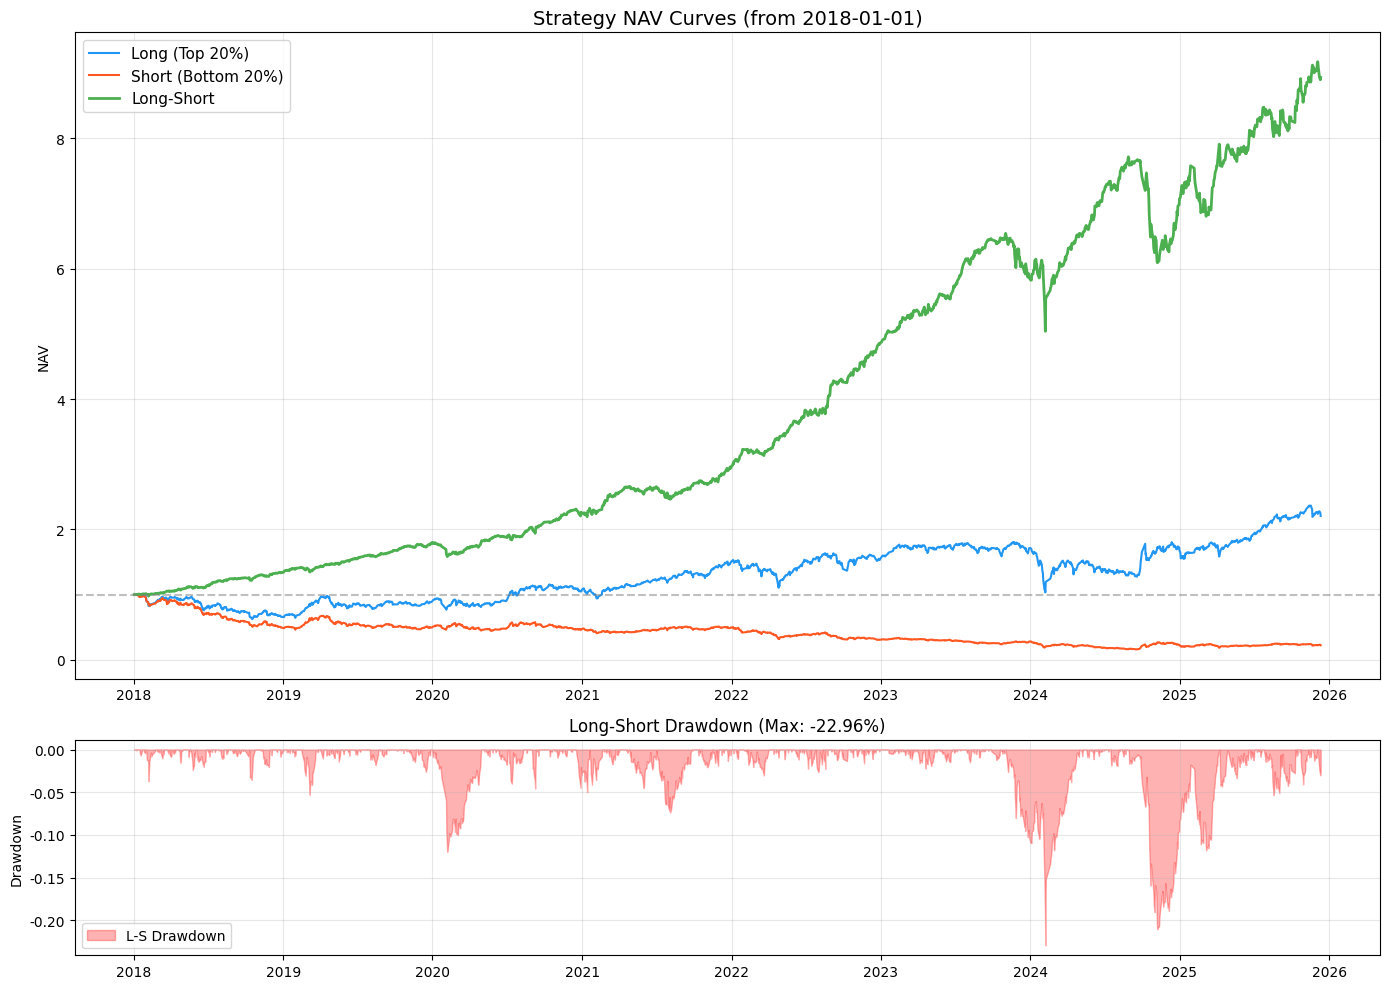

   ✅ 净值图已保存: output/backtest_multifactor/ls_dashboard.png

🏆 核心指标醒目汇总
  策略                         夏普比率       最大回撤       年化收益       累计收益
  -------------------- ---------- ---------- ---------- ----------
  Long (做多前20%)            0.4066    -42.75%    +10.91%   +120.72%
  Short (做多后20%)          -0.6253    -83.94%    -17.75%    -77.56%
  Long-Short (多空)          2.6041    -22.96%    +33.15%   +793.13%

✅ 回测完成！结果保存在: output/backtest_multifactor
   回测区间: 2018-01-01 ~ 2025-12-11
   💡 此回测 cell 可独立运行，无需先运行配置/训练 cell


In [7]:
# =============================================================================
# 🚀 步骤 4: 多因子回测 (GeneralBacktest v2.0)
# =============================================================================
#
# 回测流程：
#   1. 自动获取滚动预测结果（兼容两种训练路径）
#   2. 多因子 IC 加权集成 → 单因子
#   3. IC 统计分析 + 因子方向修正
#   4. 加载价格数据（Wind 后复权价格）
#   5. 分别运行 long / short 回测（GeneralBacktest 纯多头引擎）
#   6. 合成多空净值 + 输出绩效指标 + 可视化
#
# ⚠️ GeneralBacktest 是纯多头引擎，不支持负权重。
#    因此多空策略拆分为：long 回测 + short 反向回测 → 手动合成。
# 💡 此 cell 可独立运行，无需先运行配置/训练 cell（自动从缓存加载）
# =============================================================================

import sys
sys.path.insert(0, '/home/u2025210237/jupyterlab')

import gc
import json as _json
import importlib
import quantclassic.backtest.general_backtest.utils as _gb_utils
importlib.reload(_gb_utils)
import quantclassic.backtest.general_backtest.backtest as _gb_bt
importlib.reload(_gb_bt)
import quantclassic.backtest.general_backtest
importlib.reload(quantclassic.backtest.general_backtest)
import quantclassic.backtest.portfolio_builder as _pb
importlib.reload(_pb)
import quantclassic.backtest.general_backtest_adapter as _gb_adapter
importlib.reload(_gb_adapter)
import quantclassic.backtest
importlib.reload(quantclassic.backtest)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from quantclassic.backtest import (
    BacktestConfig,
    GeneralBacktestAdapter,
)

# 🔴 关闭所有残留图形，防止空白图片输出
plt.close('all')

print("=" * 80)
print("🚀 步骤 4: 多因子回测 (GeneralBacktest v2.0)")
print("=" * 80)

# =============================================================================
# 0. 自动检测列名和路径配置（支持独立运行）
# =============================================================================
_meta_for_cols = {}
_META_PATH_BT = Path('output/rolling_dynamic_cache/metadata.json')
if _META_PATH_BT.exists():
    with open(_META_PATH_BT, 'r') as _f:
        _meta_for_cols = _json.load(_f).get('data_path_info', {})

if 'dm' in dir() and hasattr(dm, 'config'):
    stock_col = dm.config.stock_col
    time_col  = dm.config.time_col
    label_col = dm.config.label_col
else:
    stock_col = _meta_for_cols.get('stock_col', 'order_book_id')
    time_col  = _meta_for_cols.get('time_col', 'trade_date')
    label_col = _meta_for_cols.get('label_col', 'alpha_label')
    print("   ℹ️ dm 未定义，使用缓存/默认列名配置")

if 'data_config' in dir():
    _data_path = Path(data_config.base_dir) / data_config.data_file
    _output_base = str(data_config.base_dir)
else:
    _base = _meta_for_cols.get('base_dir', 'output')
    _file = _meta_for_cols.get('data_file', 'wind_processed_all.parquet')
    _data_path = Path(_base) / _file
    _output_base = _base
    print(f"   ℹ️ data_config 未定义，使用缓存路径: {_data_path}")

# =============================================================================
# 1. 获取预测结果（自动检测训练路径）
# =============================================================================
print("\n【1. 获取预测结果】")

print(f"   stock_col: {stock_col}")
print(f"   time_col:  {time_col}")
print(f"   label_col: {label_col}")

_CACHE_DIR = Path('output/rolling_dynamic_cache')
_PRED_PATH = _CACHE_DIR / 'dynamic_predictions.parquet'
_META_PATH = _CACHE_DIR / 'metadata.json'

rolling_predictions = None

# --- 路径 A: Cell 12 动态图 RollingDailyTrainer ---
if 'rolling_dynamic_results' in dir() and rolling_dynamic_results is not None:
    _all_pred = rolling_dynamic_results.get('all_predictions')
    if _all_pred is not None and len(_all_pred) > 0:
        rolling_predictions = _all_pred.copy()
        factor_cols = rolling_dynamic_results.get('factor_cols', [])
        print(f"   📦 数据来源: rolling_dynamic_results (动态图训练)")

# --- 路径 B: Cell 13 静态图 RollingWindowTrainer ---
if rolling_predictions is None and 'training_results' in dir() and training_results is not None:
    if 'trainer' in dir() and hasattr(trainer, 'predict_all_windows'):
        rolling_predictions = trainer.predict_all_windows(training_results)
        factor_cols = [c for c in rolling_predictions.columns if c.startswith('pred_factor_')]
        print(f"   📦 数据来源: training_results (静态图训练)")

# --- 路径 C: 磁盘缓存 ---
if rolling_predictions is None and _PRED_PATH.exists():
    rolling_predictions = pd.read_parquet(_PRED_PATH)
    rolling_predictions['trade_date'] = pd.to_datetime(rolling_predictions['trade_date'])
    _meta = {}
    if _META_PATH.exists():
        with open(_META_PATH, 'r') as _f:
            _meta = _json.load(_f)
    factor_cols = _meta.get('factor_cols', [])
    print(f"   📦 数据来源: 磁盘缓存 {_CACHE_DIR}")

if rolling_predictions is None or len(rolling_predictions) == 0:
    raise ValueError(
        "❌ 未找到预测结果！请先运行训练 Cell (12 或 13)"
    )

# 🔴 回测起始日期筛选（从2018年开始）
BACKTEST_START_DATE = '2018-01-01'
rolling_predictions[time_col] = pd.to_datetime(rolling_predictions[time_col])
_before = len(rolling_predictions)
rolling_predictions = rolling_predictions[rolling_predictions[time_col] >= BACKTEST_START_DATE].copy()
print(f"   📅 回测起始: {BACKTEST_START_DATE} (筛除 {_before - len(rolling_predictions):,} 行早期数据)")

if 'factor_cols' not in dir() or not factor_cols:
    factor_cols = [c for c in rolling_predictions.columns if c.startswith('pred_factor_')]
USE_MULTIFACTOR = len(factor_cols) > 0

print(f"   预测形状: {rolling_predictions.shape}")
print(f"   时间范围: {rolling_predictions[time_col].min()} ~ "
      f"{rolling_predictions[time_col].max()}")
print(f"   {'多因子模式: ' + str(len(factor_cols)) + ' 个因子列' if USE_MULTIFACTOR else '单因子模式'}")

# =============================================================================
# 2. 准备因子 DataFrame
# =============================================================================
print("\n【2. 因子集成】")

factor_df = rolling_predictions.copy()

rename_map = {}
if stock_col != 'order_book_id':
    rename_map[stock_col] = 'order_book_id'
if time_col != 'trade_date':
    rename_map[time_col] = 'trade_date'
if rename_map:
    factor_df = factor_df.rename(columns=rename_map)
factor_df['trade_date'] = pd.to_datetime(factor_df['trade_date'])

# --- 合并日收益列 ---
if 'future_return' not in factor_df.columns:
    return_col_name = 'y_ret_1d'
    try:
        ret_df = pd.read_parquet(str(_data_path), columns=['trade_date', 'order_book_id', return_col_name])
    except Exception:
        return_col_name = label_col
        ret_df = pd.read_parquet(str(_data_path), columns=['trade_date', 'order_book_id', return_col_name])
    ret_df['trade_date'] = pd.to_datetime(ret_df['trade_date'])
    ret_df = ret_df.drop_duplicates(subset=['trade_date', 'order_book_id'])
    factor_df = factor_df.merge(
        ret_df.rename(columns={return_col_name: 'future_return'}),
        on=['trade_date', 'order_book_id'], how='left'
    )
    del ret_df; gc.collect()
print(f"   收益列: future_return "
      f"(非空 {factor_df['future_return'].notna().sum():,}/{len(factor_df):,})")

# --- 因子列确定 ---
if USE_MULTIFACTOR:
    print(f"\n   IC 加权集成 ({len(factor_cols)} 因子):")
    ic_weights = {}
    for col in factor_cols:
        col_ic = factor_df.dropna(subset=[col, 'future_return']).groupby('trade_date').apply(
            lambda x: x[col].corr(x['future_return']), include_groups=False
        ).mean()
        ic_weights[col] = max(col_ic, 0)
        print(f"     {col}: IC={col_ic:+.4f}  weight={ic_weights[col]:.4f}")
    total_w = sum(ic_weights.values())
    if total_w > 0:
        ic_weights = {k: v / total_w for k, v in ic_weights.items()}
    else:
        ic_weights = {k: 1 / len(factor_cols) for k in factor_cols}
        print("     ⚠️ 所有因子 IC ≤ 0，使用等权集成")
    factor_df['factor_raw'] = sum(factor_df[col] * w for col, w in ic_weights.items())
    FACTOR_COL = 'factor_raw'
    ensemble_weights = ic_weights
else:
    _candidates = ['factor_raw', 'factor_raw_std', 'pred', 'pred_factor_0']
    FACTOR_COL = None
    for _c in _candidates:
        if _c in factor_df.columns:
            FACTOR_COL = _c
            break
    if FACTOR_COL is None:
        raise ValueError(f"❌ 未找到因子列, 现有列: {factor_df.columns.tolist()}")
    if FACTOR_COL != 'factor_raw':
        factor_df['factor_raw'] = factor_df[FACTOR_COL]
        FACTOR_COL = 'factor_raw'
    ensemble_weights = {}
    print(f"   单因子: → '{FACTOR_COL}'")

# =============================================================================
# 3. IC 统计 + 因子方向修正
# =============================================================================
print("\n【3. IC 统计 & 方向修正】")

ic_series = factor_df.dropna(subset=[FACTOR_COL, 'future_return']).groupby('trade_date').apply(
    lambda x: x[FACTOR_COL].corr(x['future_return']),
    include_groups=False
).dropna()

ic_mean = ic_series.mean()
ic_std  = ic_series.std()
icir = ic_mean / ic_std if ic_std > 0 else 0
ic_win_rate = (ic_series > 0).mean()

print(f"   IC 均值:  {ic_mean:+.4f}")
print(f"   ICIR:     {icir:.4f}")
print(f"   IC 胜率:  {ic_win_rate:.2%}")

if ic_mean < -0.01:
    print(f"   ⚠️ IC < 0，执行因子反转")
    factor_df[FACTOR_COL] = -factor_df[FACTOR_COL]
    ic_mean = -ic_mean
    icir = -icir
    ic_win_rate = 1 - ic_win_rate
    print(f"   修正后: IC={ic_mean:+.4f}, ICIR={icir:.4f}, 胜率={ic_win_rate:.2%}")

# =============================================================================
# 4. 加载价格数据
# =============================================================================
print("\n【4. 加载价格数据】")

price_cols = ['trade_date', 'order_book_id', 'open', 'close']
try:
    price_df = pd.read_parquet(str(_data_path), columns=price_cols)
except Exception:
    _alt_path = Path('output/wind_daily_features.parquet')
    price_df = pd.read_parquet(str(_alt_path), columns=price_cols)

price_df['trade_date'] = pd.to_datetime(price_df['trade_date'])
price_df = price_df.drop_duplicates(subset=['trade_date', 'order_book_id'])

# 🔴 同步过滤价格数据，确保回测从2018年开始
price_df = price_df[price_df['trade_date'] >= BACKTEST_START_DATE].copy()

_close_max = price_df['close'].max()
print(f"   价格数据: {price_df.shape}")
print(f"   时间范围: {price_df['trade_date'].min().date()} ~ {price_df['trade_date'].max().date()}")
print(f"   股票数:   {price_df['order_book_id'].nunique():,}")
print(f"   close max: {_close_max:.2f} (Wind 后复权价格，数值大是正常的)")

# =============================================================================
# 5. 回测参数配置
# =============================================================================
output_dir = str(Path(_output_base) / 'backtest_multifactor')
Path(output_dir).mkdir(parents=True, exist_ok=True)

_common_cfg = dict(
    output_dir=output_dir,
    winsorize_method='quantile',
    winsorize_quantiles=(0.025, 0.975),
    standardize_method='zscore',
    fillna_method='median',
    n_groups=10,
    rebalance_freq='biweekly',
    weight_method='equal',
    long_ratio=0.2,
    short_ratio=0.2,
    consider_cost=True,
    commission_rate=0.0003,
    stamp_tax_rate=0.001,
    slippage_rate=0.001,
    engine='general_backtest',
    buy_price='open',
    sell_price='close',
    general_backtest_options={
        'rebalance_threshold': 0.0001,
        'initial_capital': 1.0,
        'adj_factor_col': 'adj_factor',
        'close_price_col': 'close',
    },
)

print(f"\n【5. 回测参数】")
print(f"   调仓频率:   {_common_cfg['rebalance_freq']}")
print(f"   多空比例:   多 {_common_cfg['long_ratio']:.0%} / 空 {_common_cfg['short_ratio']:.0%}")
print(f"   成本:       佣金 {_common_cfg['commission_rate']:.2%} + "
      f"印花税 {_common_cfg['stamp_tax_rate']:.1%} + "
      f"滑点 {_common_cfg['slippage_rate']:.1%}")

# =============================================================================
# 6. 拆分回测：Long + Short（GeneralBacktest 是纯多头引擎）
# =============================================================================
print(f"\n【6. 运行回测】")
print(f"   ⚠️ GeneralBacktest 不支持负权重，拆分为 long + short 两次回测")

# --- 6A. Long-only 回测（做多前 20%）---
print(f"\n   📈 [A] Long-only 回测...")
long_config = BacktestConfig(**_common_cfg)
long_adapter = GeneralBacktestAdapter(long_config)
long_results = long_adapter.run(
    factor_df=factor_df,
    price_df=price_df,
    factor_col=FACTOR_COL,
    weight_mode='long_only',
    save_plots=False,
    output_dir=output_dir,
)
plt.close('all')
long_nav = long_results.get('nav_series')
if long_nav is not None:
    print(f"   Long NAV: {long_nav.iloc[0]:.4f} → {long_nav.iloc[-1]:.4f}  "
          f"(累计 {long_nav.iloc[-1] / long_nav.iloc[0] - 1:+.2%})")

# --- 6B. Short 反向回测 ---
print(f"\n   📉 [B] Short 反向回测...")
factor_df_short = factor_df.copy()
factor_df_short[FACTOR_COL] = -factor_df_short[FACTOR_COL]

short_config = BacktestConfig(**_common_cfg)
short_adapter = GeneralBacktestAdapter(short_config)
short_results = short_adapter.run(
    factor_df=factor_df_short,
    price_df=price_df,
    factor_col=FACTOR_COL,
    weight_mode='long_only',
    save_plots=False,
    output_dir=output_dir,
)
plt.close('all')
short_nav = short_results.get('nav_series')
if short_nav is not None:
    print(f"   Short NAV: {short_nav.iloc[0]:.4f} → {short_nav.iloc[-1]:.4f}  "
          f"(累计 {short_nav.iloc[-1] / short_nav.iloc[0] - 1:+.2%})")

del factor_df_short; gc.collect()

# --- 6C. 合成多空净值 ---
print(f"\n   🔀 [C] 合成多空净值...")
common_idx = long_nav.index.intersection(short_nav.index)
long_nav_aligned = long_nav.loc[common_idx]
short_nav_aligned = short_nav.loc[common_idx]

long_ret = long_nav_aligned.pct_change().fillna(0)
short_ret = short_nav_aligned.pct_change().fillna(0)
ls_ret = long_ret - short_ret
ls_nav = (1 + ls_ret).cumprod()

print(f"   L-S NAV: {ls_nav.iloc[0]:.4f} → {ls_nav.iloc[-1]:.4f}")

# =============================================================================
# 7. 计算绩效指标
# =============================================================================
print("\n" + "=" * 80)
print("📊 回测结果汇总")
print("=" * 80)

def calc_metrics(nav_series, name=""):
    """计算策略绩效指标"""
    ret = nav_series.pct_change().dropna()
    n_years = len(ret) / 252
    cum_ret = nav_series.iloc[-1] / nav_series.iloc[0] - 1
    ann_ret = (1 + cum_ret) ** (1 / n_years) - 1 if n_years > 0 else 0
    ann_vol = ret.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    sortino_vol = ret[ret < 0].std() * np.sqrt(252)
    sortino = ann_ret / sortino_vol if sortino_vol > 0 else 0
    
    peak = nav_series.expanding().max()
    dd = (nav_series - peak) / peak
    max_dd = dd.min()
    
    calmar = ann_ret / abs(max_dd) if abs(max_dd) > 0 else 0
    win_rate = (ret > 0).mean()
    
    m = {
        '累计收益': cum_ret,
        '年化收益': ann_ret,
        '年化波动': ann_vol,
        '夏普比率': sharpe,
        '索提诺':   sortino,
        '卡玛比率': calmar,
        '最大回撤': max_dd,
        '胜率':     win_rate,
    }
    
    print(f"\n📈 {name} 绩效:")
    _fmt_map = {
        '累计收益': '{:+.2%}', '年化收益': '{:+.2%}', '年化波动': '{:.2%}',
        '夏普比率': '{:.4f}', '索提诺': '{:.4f}', '卡玛比率': '{:.4f}',
        '最大回撤': '{:.2%}', '胜率': '{:.2%}',
    }
    for k, v in m.items():
        print(f"   {k:10s}: {_fmt_map[k].format(v)}")
    return m

long_metrics = calc_metrics(long_nav_aligned, "Long (做多前20%)")
short_metrics = calc_metrics(short_nav_aligned, "Short (做多后20%)")
ls_metrics = calc_metrics(ls_nav, "Long-Short (多空)")

# --- IC 统计 ---
print(f"\n📊 IC 统计:")
print(f"   IC 均值:    {ic_mean:+.4f}")
print(f"   ICIR:       {icir:.4f}")
print(f"   IC 胜率:    {ic_win_rate:.2%}")

# --- 因子权重 ---
if ensemble_weights:
    print(f"\n⚖️ 因子权重 (Top 5):")
    for name, w in sorted(ensemble_weights.items(), key=lambda x: -x[1])[:5]:
        print(f"   {name}: {w:.4f}")

# =============================================================================
# 8. 可视化
# =============================================================================
print(f"\n📊 绘制净值曲线...")

plt.close('all')

fig, axes = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})

ax1 = axes[0]
ax1.plot(long_nav_aligned.index, long_nav_aligned.values, label='Long (Top 20%)', color='#2196F3', linewidth=1.5)
ax1.plot(short_nav_aligned.index, short_nav_aligned.values, label='Short (Bottom 20%)', color='#FF5722', linewidth=1.5)
ax1.plot(ls_nav.index, ls_nav.values, label='Long-Short', color='#4CAF50', linewidth=2)
ax1.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
ax1.set_title(f'Strategy NAV Curves (from {BACKTEST_START_DATE})', fontsize=14)
ax1.set_ylabel('NAV')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ls_peak = ls_nav.expanding().max()
ls_dd = (ls_nav - ls_peak) / ls_peak
ax2.fill_between(ls_dd.index, ls_dd.values, 0, color='red', alpha=0.3, label='L-S Drawdown')
ax2.set_title(f'Long-Short Drawdown (Max: {ls_dd.min():.2%})', fontsize=12)
ax2.set_ylabel('Drawdown')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
dashboard_path = f"{output_dir}/ls_dashboard.png"
plt.savefig(dashboard_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"   ✅ 净值图已保存: {dashboard_path}")

# =============================================================================
# 9. 夏普 & 回撤 醒目汇总
# =============================================================================
print("\n" + "=" * 80)
print("🏆 核心指标醒目汇总")
print("=" * 80)
print(f"  {'策略':<20s} {'夏普比率':>10s} {'最大回撤':>10s} {'年化收益':>10s} {'累计收益':>10s}")
print(f"  {'-'*20} {'-'*10} {'-'*10} {'-'*10} {'-'*10}")
for _name, _m in [('Long (做多前20%)', long_metrics), ('Short (做多后20%)', short_metrics), ('Long-Short (多空)', ls_metrics)]:
    print(f"  {_name:<20s} {_m['夏普比率']:>10.4f} {_m['最大回撤']:>10.2%} {_m['年化收益']:>+10.2%} {_m['累计收益']:>+10.2%}")
print("=" * 80)

# 保存结果
static_backtest_results = {
    'long_results': long_results,
    'short_results': short_results,
    'long_nav': long_nav_aligned,
    'short_nav': short_nav_aligned,
    'ls_nav': ls_nav,
    'long_metrics': long_metrics,
    'short_metrics': short_metrics,
    'ls_metrics': ls_metrics,
    'ic_stats': {'ic_mean': ic_mean, 'icir': icir, 'ic_win_rate': ic_win_rate},
}

print(f"\n✅ 回测完成！结果保存在: {output_dir}")
print(f"   回测区间: {BACKTEST_START_DATE} ~ {rolling_predictions[time_col].max().strftime('%Y-%m-%d')}")
print(f"   💡 此回测 cell 可独立运行，无需先运行配置/训练 cell")

In [12]:
# =============================================================================
# 🔬 可选：对比不同集成方法
# =============================================================================
# 
# 这个单元格会自动对比 3 种集成方法：
#   - mean:        简单平均
#   - ic_weighted: IC 加权平均
#   - best:        选择最佳单因子
#
# 运行后可以看到哪种方法效果最好
#
# 🔴 修复：
#   - 确保 backtest 和 backtest_config 存在
#   - 如果不存在则自动创建（支持独立运行此单元格）
# =============================================================================

import sys
sys.path.insert(0, '/home/u2025210237/jupyterlab')

from pathlib import Path
import pandas as pd

print("=" * 80)
print("🔬 多集成方法对比")
print("=" * 80)

# =============================================================================
# 0. 检查必要变量
# =============================================================================

# 检查 rolling_predictions 是否存在
if 'rolling_predictions' not in dir():
    raise ValueError(
        "❌ 未找到 rolling_predictions！\n"
        "   请先运行上一个单元格（一键回测）生成预测结果"
    )

# 检查 backtest_config 是否存在，不存在则创建
if 'backtest_config' not in dir():
    print("  ⚠️ backtest_config 不存在，正在创建...")
    from quantclassic.backtest import BacktestConfig
    
    backtest_preset = dict(
        output_dir=str(Path(data_config.base_dir) / 'backtest_multifactor'),
        winsorize_method='quantile',
        winsorize_quantiles=getattr(data_config, 'winsorize_quantiles', (0.025, 0.975)),
        standardize_method='zscore',
        fillna_method=getattr(data_config, 'fillna_method', 'median'),
        n_groups=getattr(data_config, 'n_groups', 10),
        rebalance_freq=getattr(data_config, 'rebalance_freq', 'biweekly'),
        weight_method='equal',
        long_ratio=getattr(data_config, 'long_ratio', 0.2),
        short_ratio=getattr(data_config, 'short_ratio', 0.2),
        consider_cost=True,
        commission_rate=getattr(data_config, 'commission_rate', 0.0003),
        stamp_tax_rate=getattr(data_config, 'stamp_tax_rate', 0.001),
        slippage_rate=getattr(data_config, 'slippage_rate', 0.001),
        save_plots=True,
        generate_excel=True,
        report_title="多因子模型回测报告"
    )
    backtest_config = BacktestConfig(**backtest_preset)
    print("  ✓ backtest_config 已创建")

# 检查 backtest 是否存在，不存在则创建
if 'backtest' not in dir():
    print("  ⚠️ backtest 不存在，正在创建...")
    from quantclassic.backtest import MultiFactorBacktest
    backtest = MultiFactorBacktest(backtest_config)
    print("  ✓ backtest 已创建")

print("  ✓ 所有依赖检查通过")

# =============================================================================
# 1. 对比多种集成方法
# =============================================================================
print("\n【1】运行多集成方法对比")

comparison_results = backtest.run_multi_ensemble(
    rolling_predictions,
    stock_col=dm.config.stock_col,
    time_col=dm.config.time_col,
    label_col=dm.config.label_col,
    methods=['mean', 'ic_weighted', 'best']
)

# =============================================================================
# 2. 汇总对比表格
# =============================================================================
print("\n【2】汇总结果")

comparison_data = []
for method, res in comparison_results.items():
    method_ic_stats = res.get('ic_stats', {})
    method_metrics = res.get('metrics', {})
    ls = method_metrics.get('long_short', {})
    
    comparison_data.append({
        '集成方法': method,
        'IC均值': method_ic_stats.get('ic_mean', 0),
        'ICIR': method_ic_stats.get('icir', 0),
        'IC胜率': method_ic_stats.get('ic_win_rate', 0),
        '年化收益': ls.get('annual_return', 0),
        '夏普比率': ls.get('sharpe_ratio', 0),
        '最大回撤': ls.get('max_drawdown', 0)
    })

comparison_df = pd.DataFrame(comparison_data)

# 格式化显示
print("\n📊 集成方法效果对比:")
print(comparison_df.to_string(index=False, formatters={
    'IC均值': '{:+.4f}'.format,
    'ICIR': '{:.4f}'.format,
    'IC胜率': '{:.2%}'.format,
    '年化收益': '{:+.2%}'.format,
    '夏普比率': '{:.4f}'.format,
    '最大回撤': '{:.2%}'.format
}))

# 找出最佳方法
best_method = comparison_df.loc[comparison_df['ICIR'].idxmax(), '集成方法']
print(f"\n🏆 推荐使用: {best_method} (ICIR最高)")

print("\n" + "=" * 80)
print("✅ 对比完成！各方法结果保存在对应文件夹")
print("=" * 80)

🔍 回测全零问题诊断

1. backtest_results 键:
   nav_series: Series len=6199, min=1.000000, max=1.000000
   positions: DataFrame (0, 0)
   trade_records: DataFrame (409, 5)
   metrics: dict keys=['累计收益率', '年化收益率', '年化波动率', '夏普比率', '索提诺比率', '卡玛比率', '胜率', 'VaR (95%)', 'CVaR (95%)', '最大回撤']
   weights_data: DataFrame (512800, 3)
   bt_instance: GeneralBacktest

2. weights_data:
   形状: (512800, 3)
   列名: ['date', 'code', 'weight']
   前5行:
        date       code    weight
0 2010-10-29  600277.SH  0.000676
1 2010-10-29  600238.SH  0.000676
2 2010-10-29  002166.SZ  0.000676
3 2010-10-29  600137.SH  0.000676
4 2010-10-29  300009.SZ  0.000676
   weight 统计: min=-0.000676, max=0.000676, mean=-0.000000
   日期数: 409
   日期范围: 2010-10-29 00:00:00 ~ 2025-12-11 00:00:00
   每日权重和(前5日):
     2010-10-29 00:00:00: 592 stocks, weight_sum=0.000000
     2010-11-12 00:00:00: 592 stocks, weight_sum=0.000000
     2010-11-26 00:00:00: 602 stocks, weight_sum=-0.000000
     2010-12-10 00:00:00: 608 stocks, weight_sum=0.000000